# Style Transfer Neural Network

In [1]:
from __future__ import division
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
%matplotlib inline

Using TensorFlow backend.


## Model Pre-processing

In [2]:
def _weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b

def _relu(layer):
    return tf.nn.relu(layer)

def _conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = _weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

def _relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return _relu(_conv2d(previous_layer, layer, layer_name, model_layers))

def _avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    

In [3]:
def get_vgg19_model(height=512, width=512):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = _relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = _relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = _avg_pool(model['conv1_2'])
    model['conv2_1'] = _relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = _relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = _avg_pool(model['conv2_2'])
    model['conv3_1']  = _relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = _relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = _relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['conv3_4']  = _relu_conv2d(model['conv3_3'], 16, 'conv3_4', layers)
    model['avgpool3'] = _avg_pool(model['conv3_4'])
    model['conv4_1']  = _relu_conv2d(model['avgpool3'], 19, 'conv4_1', layers)
    model['conv4_2']  = _relu_conv2d(model['conv4_1'], 21, 'conv4_2', layers)
    model['conv4_3']  = _relu_conv2d(model['conv4_2'], 23, 'conv4_3', layers)
    model['conv4_4']  = _relu_conv2d(model['conv4_3'], 25, 'conv4_4', layers)
    model['avgpool4'] = _avg_pool(model['conv4_4'])
    model['conv5_1']  = _relu_conv2d(model['avgpool4'], 28, 'conv5_1', layers)
    model['conv5_2']  = _relu_conv2d(model['conv5_1'], 30, 'conv5_2', layers)
    model['conv5_3']  = _relu_conv2d(model['conv5_2'], 32, 'conv5_3', layers)
    model['conv5_4']  = _relu_conv2d(model['conv5_3'], 34, 'conv5_4', layers)
    model['avgpool5'] = _avg_pool(model['conv5_4'])
    return model

In [4]:
vgg19 = get_vgg19_model()

In [5]:
#Definiying height and width
height, width = (512, 512)

In [28]:
#Layers to calculate style cost
STYLE_LAYERS = [
    ('conv1_1', 0.1),
    ('conv2_1', 0.1),
    ('conv3_1', 0.3),
    ('conv4_1', 0.3),
    ('conv5_1', 0.2)]

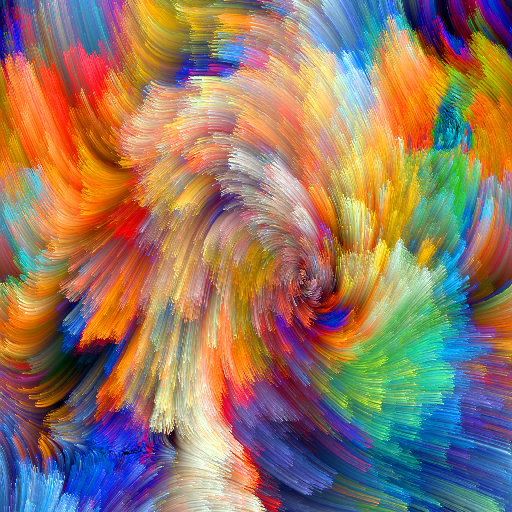

In [7]:
#Style Image
style_image = Image.open('./images/art_style_1.jpg')
style_image = style_image.resize((height, width))
style_image

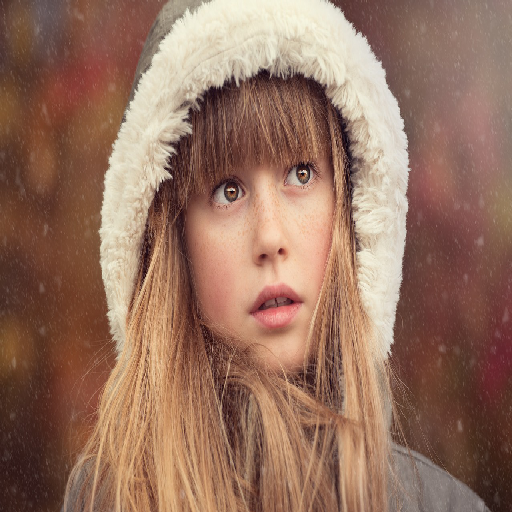

In [8]:
#Content Image
content_image = Image.open('./images/content.jpg')
content_image = content_image.resize((height, width))
content_image

In [9]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H * n_W, n_C])
    J_content = (1/(4 * n_H * n_C * n_W))  * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [10]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [11]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S), [n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G), [n_C, n_H * n_W])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1 / (4 * n_C**2 * (n_H * n_W)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [14]:
def preprocess_image(path, height = 512, width = 512):
    #Means from VGG19 paper
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    array_image = image.load_img(path, target_size = (height, width))
    array_image = image.img_to_array(array_image) 
    array_image = np.reshape(array_image, ((1,) + array_image.shape))    
    array_image -= means
    return array_image

In [15]:
def generate_random_image(content_image, noise_ratio = 0.6, height = 512, width = 512):
    noise_image = np.random.uniform(-20, 20, (1, height, width, 3)).astype('float32')
    random_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return random_image

In [16]:
def deprocess_image(image):
    #Means from VGG19 paper
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image += means
    return image

In [17]:
def save_image(path, image):    
    # Un-normalize the image so that it looks good
    image = deprocess_image(image)    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [29]:
#Creating content image, style image and generated image
content_image = preprocess_image('./images/content.jpg')
style_image = preprocess_image('./images/art_style_1.jpg')
generated_image = generate_random_image(content_image)

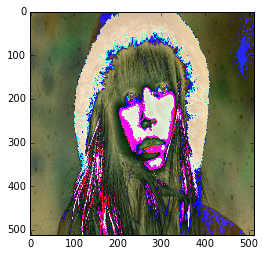

In [30]:
imshow(content_image[0])

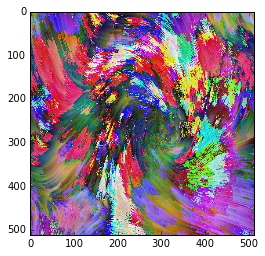

In [20]:
imshow(style_image[0])

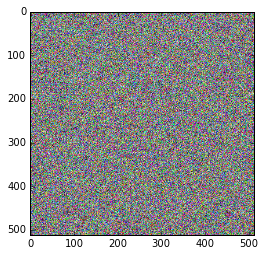

In [31]:
imshow(generated_image[0])

In [32]:
#Creating a TF session
sess = tf.Session()

In [33]:
#Calculate Cost
# Assign the content image to be the input of the VGG model.  
sess.run(vgg19['input'].assign(content_image))
out = vgg19['conv4_2']
a_C = sess.run(out)
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(vgg19['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(vgg19, STYLE_LAYERS)
J = total_cost(J_content, J_style)

#Optimizer
optimizer = tf.train.AdamOptimizer(1.2)

train_step = optimizer.minimize(J)

In [ ]:
print(vgg19)

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

In [34]:
def generate_image(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(vgg19['input'].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(vgg19['input'])
        if i % 10 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + "-style.png", generated_image)
    return deprocess_image(generated_image)

In [ ]:
my_image = generate_image(sess, generated_image)

Iteration 0 :
total cost = 6.63029e+10
content cost = 6138.24
style cost = 1.65757e+09


In [27]:
save_image("output/-final.png", my_image)